# gBWT

Run BWT on graph.

The concept of gBWT is similar to linear one.

First step is sorting all the suffix array,
which is equivalent to sort all the possible paths

Second step is assigning the node with unique rank,
(It is already unique in suffix array of linear string in previous tutorial). 
Assigning require slightly modifiy the graph in order to avoid sandwitch condition
(e.g. rank0 and rank2 paths are from the same node),
The modified graph is called prefix-sorted automaton.

The last step is calculating the BWT as before,
but be aware of the case of indegree > 1 and outdegree > 1,
those cases shows the index of BWT and index of node is not always 1 to 1
and require mapping.

Reference: https://pubmed.ncbi.nlm.nih.gov/26355784/

## ToC
1. Setup reference
2. Build prefix-sorted automaton
    1. Prefix doubling first step
    2. Prefix doubling
    3. Reconstruct graph
    
3. Build BWT index

    1. BWT occurances
    2. BWT start position
    3. SA to BWT index mapping
    
4. Search pattern

## 1. Setup Reference

We assume the input graph is already reverse-deterministic
(No two different paths (extended to $) are same in string)

In [1]:
from collections import Counter, defaultdict
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt


def plot(g: nx.DiGraph, label_func):
    labels = {i: label_func(i) for i in g.nodes}
    nx.draw(g, labels=labels, node_color=(0, 0, 0, 0))
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


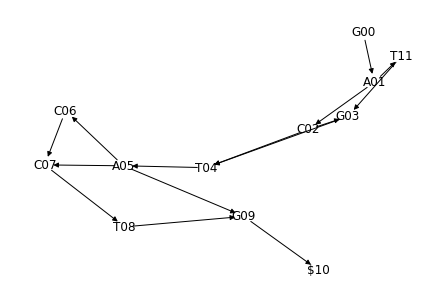

In [2]:
"""
        ---      ---
       /   \    /   \
G0 A1 C2 G3 T4 A5 C6 C7 T8 G9 $10
    \   /       \          /
     T11         ----------
"""
c = 0
g = nx.DiGraph()
backbone = "GACGTACCTG$"
for s in backbone:
    g.add_node(c, ch=s)
    if c > 0:
        g.add_edge(c - 1, c)
    c += 1

# T11 insertion
g.add_node(c, ch="T")
g.add_edge(1, c)
g.add_edge(c, 3)
c += 1

# deletion
g.add_edge(2, 4)
g.add_edge(5, 7)
g.add_edge(5, 9)

# init
chrs = sorted(set(nx.get_node_attributes(g, 'ch').values()))
end_chr = "$"
def nodeName(i):
    return f"{g.nodes[i]['ch']}{i:02d}"
plot(g, nodeName)

## 2.1 Prefix doubling (first step)

We represent the path in the form `(from, to, rank)`,

which starts from the `from` node and ends with `to` node,

but the underline string does not include the label of node `to`.

(This is a easier way to implement the algorithm)

In [3]:
prefix_leng = 1
path_rank = {}  # key = (from, to) value = comparable value
paths = []      # list[tuple[from, to, rank]]
for a, ch in g.nodes(data='ch'):
    for _, b in g.out_edges(a):  # all possible edges
        path_rank[(a, b)] = ch
    if not len(g.out_edges(a)):  # $ has no outgoing edge
        assert ch == end_chr
        path_rank[(a, b)] = ch

# calculate the rank by it's value
prev_rank, prev_v = None, None
for rank, (k, v)  in enumerate(sorted(path_rank.items(), key=lambda i: i[1])):
    if v == prev_v:
        paths.append((*k, prev_rank))
    else:
        prev_rank, prev_v = rank, v
        paths.append((*k, rank))

# print
print(f"Prefix Length = {prefix_leng}")
print("From   To  Rank")
for a, b, v in paths:
    print(f"{nodeName(a)} -> {nodeName(b)} {v}")

Prefix Length = 1
From   To  Rank
$10 -> $10 0
A01 -> C02 1
A01 -> T11 1
A05 -> C06 1
A05 -> C07 1
A05 -> G09 1
C02 -> G03 6
C02 -> T04 6
C06 -> C07 6
C07 -> T08 6
G00 -> A01 10
G03 -> T04 10
G09 -> $10 10
T04 -> A05 13
T08 -> G09 13
T11 -> G03 13


## 2.2 Prefix doubling (doubling step)

Next, we run prefix doubling on graph, similar the way in linear.

The new rank of position `k` in linear prefix doubling is `(rank[k], rank[k+leng])`,
similarly, the new rank of node `k` in graph is `(rank[(k_from, k_to)], rank[(v_from, v_to)])`, where `k_to = v_from`.

The `(from, to, rank)` indicates any string/nodes between `from` and `to` are not saved,
because we only care about the **order** which is already saved as `rank`.
i.e. if there exists different paths that has same `(from, to)`, the rank must be different.

To reduce the computation, the path will be pruned if those paths are not important.
i.e. The node are not sandwitched and not needed to extend/doubling the string/path.

In [4]:
while len(set(map(lambda i: i[-1], paths))) != len(paths):  # unique rank = all sorted
    node_sorted = set(k for k, v in Counter(map(lambda i: i[-1], paths)).items() if v == 1)

    # Group path by `from`
    # type: {node: [all paths from the node]}
    path_from = defaultdict(list)
    for path in paths:
        path_from[path[0]].append(path)

    # go through all possible paths
    path_rank = {}
    for path in paths:
         # if sorted -> skip
        if path[2] in node_sorted:
            path_rank[(path, path)] = (path[-1], -1)
            continue
        assert path[1] in path_from
        for path_to in path_from[path[1]]:
            path_rank[(path, path_to)] = (path[-1], path_to[-1])

    # calculate the rank by it's value
    paths = []
    tmp_path_history = {}
    prev_rank, prev_v = None, None
    for rank, ((a, b), v)  in enumerate(sorted(path_rank.items(), key=lambda i: i[1])):
        if v == prev_v:
            path = (a[0], b[1], prev_rank)
        else:
            prev_rank, prev_v = rank, v
            path = (a[0], b[1], rank)
        paths.append(path)
    
        if a == b:
            tmp_path_history[path] = None, v
        else:
            tmp_path_history[path] = a[1], v
    
    # Collect the nodes with same rank for pruneing
    rank_from = defaultdict(set)  # key: rank, value: set of from node
    for a, _, rank in paths:
        rank_from[rank].add(a)
        
    # print
    prefix_leng *= 2
    print(f"Prefix Length = {prefix_leng}")
    print("From  Transfer  To Rank")
    
    new_paths = []
    for a, b, rank in paths:
        # print
        transfre_node, old_rank = tmp_path_history[(a, b, rank)]
        print( f" {nodeName(a)} ->" + \
              (f" {nodeName(transfre_node)} ->" if transfre_node is not None else " " * 7) +
               f" {nodeName(b)} " + \
               f"({old_rank[0]:2d}, {old_rank[1]:2d}) = {rank:2d} ", end="")
        
        # prune criteria
        if new_paths and new_paths[-1][0] == a and new_paths[-1][-1] == rank and len(rank_from[rank]) == 1:
            print("pruned")
        elif new_paths and new_paths[-1][0] == a and len(rank_from[rank]) == 1 and len(rank_from[new_paths[-1][-1]]) == 1:
            print("pruned")
        else:
            print()
            prev_from = a
            new_paths.append((a, b, rank))
    paths = new_paths  # pruned paths

Prefix Length = 2
From  Transfer  To Rank
 $10 ->        $10 ( 0, -1) =  0 
 A01 -> C02 -> G03 ( 1,  6) =  1 
 A01 -> C02 -> T04 ( 1,  6) =  1 
 A05 -> C06 -> C07 ( 1,  6) =  1 
 A05 -> C07 -> T08 ( 1,  6) =  1 
 A05 -> G09 -> $10 ( 1, 10) =  5 
 A01 -> T11 -> G03 ( 1, 13) =  6 
 C06 -> C07 -> T08 ( 6,  6) =  7 
 C02 -> G03 -> T04 ( 6, 10) =  8 
 C02 -> T04 -> A05 ( 6, 13) =  9 
 C07 -> T08 -> G09 ( 6, 13) =  9 
 G09 -> $10 -> $10 (10,  0) = 11 
 G00 -> A01 -> C02 (10,  1) = 12 
 G00 -> A01 -> T11 (10,  1) = 12 pruned
 G03 -> T04 -> A05 (10, 13) = 14 
 T04 -> A05 -> C06 (13,  1) = 15 
 T04 -> A05 -> C07 (13,  1) = 15 pruned
 T04 -> A05 -> G09 (13,  1) = 15 pruned
 T08 -> G09 -> $10 (13, 10) = 18 
 T11 -> G03 -> T04 (13, 10) = 18 
Prefix Length = 4
From  Transfer  To Rank
 $10 ->        $10 ( 0, -1) =  0 
 A05 -> C07 -> G09 ( 1,  9) =  1 
 A01 -> G03 -> A05 ( 1, 14) =  2 
 A01 -> T04 -> C06 ( 1, 15) =  3 pruned
 A05 -> T08 -> $10 ( 1, 18) =  4 
 A05 ->        $10 ( 5, -1) =  5 pruned
 A

## 2.3 Reconstruct the graph

The original node may be duplicated into two or more nodes to avoid sandwitch,
so in this stage, we try to map the original node to the new node.

The new nodes are the `from_node` in the path sorted by `rank`.
The original edges `(edge_from, edge_from)` are outer joined by new nodes on `edge_from`
and sorted by `(edge_from_label, rank_new_node)`

Thus, the order of new nodes and the order of original edges are the equivalent (both sorted by `from_node`),
the inner join of this two tables on `edge_from` and `new nodes` generate the new edges.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Path
Rank From ->   To NewNode
   0  $10 ->  $10  0($10)
   1  A05 ->  G09  1(A05)
   2  A01 ->  A05  2(A01)
   4  A05 ->  $10  4(A05)
   6  A01 ->  G03  6(A01)
   7  C06 ->  T08  7(C06)
   8  C02 ->  T04  8(C02)
  12  C07 ->  $10 12(C07)
  13  G09 ->  $10 13(G09)
  14  G00 ->  C02 14(G00)
  15  G03 ->  A05 15(G03)
  16  T04 ->  C06 16(T04)
  17  T08 ->  $10 17(T08)
  18  T11 ->  C06 18(T11)

Original Edges
From ->  To  Newnodes
 G00 -> A01  2(A01)  6(A01)
 A01 -> C02  8(C02)
 A01 -> T11 18(T11)
 C02 -> G03 15(G03)
 C02 -> T04 16(T04)
 G03 -> T04 16(T04)
 T04 -> A05  1(A05)  4(A05)
 A05 -> C06  7(C06)
 A05 -> C07 12(C07)
 A05 -> G09 13(G09)
 C06 -> C07 12(C07)
 C07 -> T08 17(T08)
 T08 -> G09 13(G09)
 G09 -> $10  0($10)
 T11 -> G03 15(G03)

Sorted original edges
From -> Newnode To_rank
 A05 ->  7(C06)  7
 A01 ->  8(C02)  8
 A05 -> 12(C07) 12
 A05 -> 13(G09) 13
 A01 -> 18(T11) 18
 C06 -> 12(C07) 12
 C02 -> 15(G03) 15
 C02 -> 16(T04) 16
 C07 -> 17(T08) 17
 G09 ->  0($10)  0
 G00 ->  2(A01

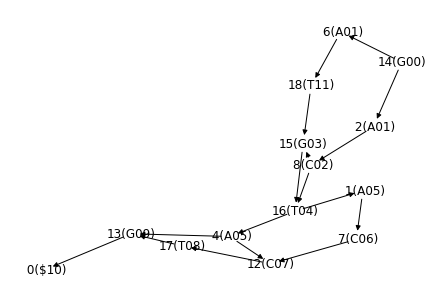

In [5]:
# init
new_g = nx.DiGraph()
def newNodeName(i):
    return f"{i:2d}({new_g.nodes[i]['ch']}{new_g.nodes[i]['origin']:02d})"

# from node in path = new node
old_id_mapping = defaultdict(list)  # key: old_id, value: list of new id
for a, _, rank in paths:
    new_g.add_node(rank, **{  # rank is unique, so use it as id is OK
        'ch': g.nodes[a]['ch'],
        'origin': a,
        'rank': rank,
    })
    old_id_mapping[a].append(rank)

# prints
print("Path")
print("Rank From ->   To NewNode")
for a, b, rank in paths:
    print(f"{rank:4d} {nodeName(a):>4s} -> {nodeName(b):>4s} {newNodeName(rank)}")
print()

# old edges: [(old_a, old_b)] => [(old_id, new_id1), (old_id, new_id1), ..]
print("Original Edges")
print("From ->  To  Newnodes")
old_edges = []
for a, b in g.edges:
    for id in old_id_mapping[b]:
        old_edges.append((a, id))
    print(f" {nodeName(a)} -> {nodeName(b)} {' '.join(newNodeName(i) for i in old_id_mapping[b])}")
# sort by rank (old_a) which is equivalent to sorted by (char, rank)
old_edges = sorted(old_edges, key=lambda i: (g.nodes[i[0]]['ch'], new_g.nodes[i[1]]['rank']))

# print
print()
print("Sorted original edges")
print("From -> Newnode To_rank")
for a, b in old_edges:
    print(f" {nodeName(a)} -> {newNodeName(b)} {new_g.nodes[b]['rank']:2d}")
print()

# Find the new edges
# (old_id, new_id1) -> (new_id, new_id1)
print("Inner join =>")
print("Newnode From -> Newnode To_rank")
prev_from = None
for a, b in old_edges:
    if a != prev_from and prev_from is not None:
        old_id_mapping[prev_from].pop(0)
    new_a = old_id_mapping[a][0]  # the order of nodes = the order of original edges 
    new_g.add_edge(new_a, b)
    print(f"{newNodeName(new_a):>7s} {nodeName(a):>4s} -> {newNodeName(b):>7s} {new_g.nodes[b]['rank']:2d}")
    prev_from = a

plot(new_g, newNodeName)

Result:
```                                           
         2(A1) ---- 8(C2)---------16(T4) - 1(A5)--7(C6)
        /               \       /        \           \
14(G0) - 6(A1)-18(T11)----15(G3)          -4(A5)------12(C7)--17(T8)--13(G9)--0($10)
                                               \                       /
                                                -----------------------                                               
```

## 3. Build BWT

BWT = The previous character before the first element in suffix array = node's in_edges

In linear, all the cases is one-sa mapped to one-BWT.

Yet in the graph,
there are two other cases will have duplicated nodes and require the index mapping.
* one sa to multiple BWT  (node's in_degree > 1)
* one BWT to multiple SA  (node's out_degree > 1)

In [6]:
# connect $ to start characters
end_id = None
for id, data in new_g.nodes.items():
    if data['ch'] == end_chr:
        end_id = id
        break
assert end_id != None
for id, degree in new_g.in_degree:
    if not degree:
        new_g.add_edge(end_id, id)
        print(f"Connect {newNodeName(end_id)} -> {newNodeName(id)}")

# Build BWT Init
sa = sorted(new_g.nodes)  # id = rank
bwt = ""
occurs = [{i: 0 for i in chrs}]
sa_to_bwt = [0]  # index mapping
bwt_to_sa = []  # index mapping
sa_to_node = {}  # sa index to node id

# print
occur_str = ' '.join(f"{i:>2s}" for i in occurs[0])
print(f" Suffix     BWT SA->BWT {occur_str} BWT->SA")

# Build BWT
for sa_index, sa_id in enumerate(sa):
    tmp_bwt_to_sa = []
    sa_to_node[sa_index] = sa_id
    for _ in range(new_g.out_degree(sa_id)):
        tmp_bwt_to_sa.append(len(bwt_to_sa))
        bwt_to_sa.append(sa_index)

    for bwt_id, _ in sorted(new_g.in_edges(sa_id)):
        ch = new_g.nodes[bwt_id]['ch']
        bwt += ch
        occurs.append(dict(occurs[-1]))
        occurs[-1][ch] += 1
        
        # print
        occur_str = ' '.join(f"{i:2d}" for i in occurs[-1].values())
        if tmp_bwt_to_sa:
            print(f"{newNodeName(sa_id)} {newNodeName(bwt_id)} {sa_index:2d}-> {len(bwt):2d} "
                  f"{occur_str} {tmp_bwt_to_sa}->{bwt_to_sa[-1]:2d}")
            tmp_bwt_to_sa = []
        else:
            print(f"{' ' * 7} {newNodeName(bwt_id)} {' ' * 4} {len(bwt):2d} "
                  f"{occur_str}")
    sa_to_bwt.append(len(bwt))
        
# start position
pos = 0
count = {}
print("Char -> BWT Position")
for ch in chrs:
    count[ch] = pos
    pos += occurs[-1][ch]
    print(f"{ch:4s} -> {count[ch]:2d}")

Connect  0($10) -> 14(G00)
 Suffix     BWT SA->BWT  $  A  C  G  T BWT->SA
 0($10) 13(G09)  0->  1  0  0  0  1  0 [0]-> 0
 1(A05) 16(T04)  1->  2  0  0  0  1  1 [1]-> 1
 2(A01) 14(G00)  2->  3  0  0  0  2  1 [2]-> 2
 4(A05) 16(T04)  3->  4  0  0  0  2  2 [3, 4]-> 3
 6(A01) 14(G00)  4->  5  0  0  0  3  2 [5]-> 4
 7(C06)  1(A05)  5->  6  0  1  0  3  2 [6]-> 5
 8(C02)  2(A01)  6->  7  0  2  0  3  2 [7, 8]-> 6
12(C07)  4(A05)  7->  8  0  3  0  3  2 [9]-> 7
         7(C06)       9  0  3  1  3  2
13(G09)  4(A05)  8-> 10  0  4  1  3  2 [10]-> 8
        17(T08)      11  0  4  1  3  3
14(G00)  0($10)  9-> 12  1  4  1  3  3 [11, 12]-> 9
15(G03)  8(C02) 10-> 13  1  4  2  3  3 [13]->10
        18(T11)      14  1  4  2  3  4
16(T04)  8(C02) 11-> 15  1  4  3  3  4 [14, 15]->11
        15(G03)      16  1  4  3  4  4
17(T08) 12(C07) 12-> 17  1  4  4  4  4 [16]->12
18(T11)  6(A01) 13-> 18  1  5  4  4  4 [17]->13
Char -> BWT Position
$    ->  0
A    ->  1
C    ->  6
G    -> 10
T    -> 14


## 4. Searching Pattern

Same in original BWT but need index mapping

In [7]:
target = "AC"  # change this
print(f"Find {target}")

print(f"Find Index => SA -> BWT => occur + count => BWT -> SA")
ps, pe = 0, len(sa_to_node) - 1
for i in range(len(target) - 1, -1, -1):
    ch = target[i]
    ps1 = sa_to_bwt[ps]
    pe1 = sa_to_bwt[pe + 1] - 1
    ps2 = occurs[ps1][ch]
    pe2 = occurs[pe1 + 1][ch] - 1
    ps3 = ps2 + count[ch]
    pe3 = pe2 + count[ch]
    ps4 = bwt_to_sa[ps3]
    pe4 = bwt_to_sa[pe3]
    print(f"{ch:>4s} {i:2d}\n"
          f"        ps => {ps:2d} -> {ps1:3d} => {ps2:5d} + {count[ch]:5d} => {ps3:3d} -> {ps4:2d}\n"
          f"        pe => {pe:2d} -> {pe1:3d} => {pe2:5d} + {count[ch]:5d} => {pe3:3d} -> {pe4:2d}")
    ps = ps4
    pe = pe4
    if ps > pe:
        raise ValueError("Cannot Found")
    # print(f"pe={pe:2d}  => ")

print("Matched position: (Input graph position)")
for id in range(ps, pe + 1):
    print(newNodeName(sa_to_node[id]))

Find AC
Find Index => SA -> BWT => occur + count => BWT -> SA
   C  1
        ps =>  0 ->   0 =>     0 +     6 =>   6 ->  5
        pe => 13 ->  17 =>     3 +     6 =>   9 ->  7
   A  0
        ps =>  5 ->   5 =>     0 +     1 =>   1 ->  1
        pe =>  7 ->   8 =>     2 +     1 =>   3 ->  3
Matched position: (Input graph position)
 1(A05)
 2(A01)
 4(A05)
